In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from ipywidgets import interact
from skimage.transform import resize
from fastai import *
from fastai.vision.all import *

import sys
# import band plotter
sys.path.append('..')
from src.band_plotters import plot, DATA_DIRECTORY, plot_from_bands_picture, plot_from_bands_tensor
from src.Tiff32Image import TiffImage, TiffImageNoised

## Constants and Selected Values

In [2]:
THRESHOLD = 4 # eV
RERUN = False

MAX_BANDS_NEAR_EFERMI =  189
MAX_BANDS =  260
MAX_WIDTH =  126

# determined from cell below - these are good maximums to ~2000th material - if exceeded values will be set to max
MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI =  7
MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI =  -7

# Used for images
SELECTED_WIDTH = 64
SELECTED_HEIGHT = 64 # max height of 130 up to 2400th material - we can crop if height > max_height

### Determining Constants for Image Processing

In [3]:
if RERUN:
    df_template = pd.read_csv("../fingerprints/template.csv", index_col="ID")
    MAX_BANDS = 0
    MAX_WIDTH = 0
    MAX_BANDS_NEAR_EFERMI = 0
    MAX_ENERGY_MINUS_EFERMI = 0
    MIN_ENERGY_MINUS_EFERMI = 0
    MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI = 0
    MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI = 0
    
    
    for i, material_id in enumerate(df_template.index):
        file_name = DATA_DIRECTORY/f"bands/{material_id}.json"
        bands_dict=json.load(open(file_name))
        energy_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
        
        # determine max height of images
        distance_from_efermi = np.abs(energy_minus_efermi)
        # mask = (distance_from_efermi < THRESHOLD).any(axis=1)
        mask = distance_from_efermi.mean(axis=1)<THRESHOLD
        if MAX_BANDS_NEAR_EFERMI < mask.sum():
            MAX_BANDS_NEAR_EFERMI = mask.sum()
            print(f"{material_id}: new max height with threshold ({THRESHOLD}): {MAX_BANDS_NEAR_EFERMI}")
        
        if MAX_BANDS < energy_minus_efermi.shape[0]:
            MAX_BANDS = energy_minus_efermi.shape[0]
            print(f"{material_id}: new max height without theshold: {MAX_BANDS}")
            
        if MAX_WIDTH < energy_minus_efermi.shape[1]:
            MAX_WIDTH = energy_minus_efermi.shape[1]
            print(f"{material_id}: new max width: {MAX_WIDTH}")
            
        if MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI < energy_minus_efermi[mask].max():
            MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI = energy_minus_efermi[mask].max()
            print(f"{material_id}: new max energy with threshold ({THRESHOLD}): {MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI}")
            
        if MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI > energy_minus_efermi[mask].min():
            MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI = energy_minus_efermi[mask].min()
            print(f"{material_id}: new min energy with threshold ({THRESHOLD}): {MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI}")
            
        if MAX_ENERGY_MINUS_EFERMI < energy_minus_efermi.max():
            MAX_ENERGY_MINUS_EFERMI = energy_minus_efermi.max()
            print(f"{material_id}: new max energy without threshold: {MAX_ENERGY_MINUS_EFERMI}")
            
        if MIN_ENERGY_MINUS_EFERMI > energy_minus_efermi.min():
            MIN_ENERGY_MINUS_EFERMI = energy_minus_efermi.min()
            print(f"{material_id}: new min energy without threshold: {MIN_ENERGY_MINUS_EFERMI}")
            
        if i % 200 == 0:
            print(i, "/", len(df_template))
            
        
    print("MAX_BANDS_NEAR_EFERMI = ", MAX_BANDS_NEAR_EFERMI)
    print("MAX_BANDS = ", MAX_BANDS)
    print("MAX_WIDTH = ", MAX_WIDTH)
    print("MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI = ", MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI)
    print("MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI = ", MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI)
    print("MAX_ENERGY_MINUS_EFERMI = ", MAX_ENERGY_MINUS_EFERMI)
    print("MIN_ENERGY_MINUS_EFERMI = ", MIN_ENERGY_MINUS_EFERMI)

## Visualizing Energy Values

In [4]:
def get_bands_that_come_near_fermi_level(bands_dict, threshold=THRESHOLD):
    '''
    band_dict["bands"]["1"] - band energy eigenvalues
    band_dict["efermi"] - fermi energy
    threshold - distance that bands must approach (at any point!) to be included
    '''
    energy_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
    distance_from_efermi = np.abs(energy_minus_efermi)
    mask = (distance_from_efermi < 8).any(axis=1)
    return energy_minus_efermi[mask]

In [5]:
def get_bands_that_average_near_fermi_level(bands_dict, threshold=THRESHOLD):
    '''
    band_dict["bands"]["1"] - band energy eigenvalues
    band_dict["efermi"] - fermi energy
    threshold - distance that bands must approach (at any point!) to be included
    '''
    energy_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
    distance_from_efermi = np.abs(energy_minus_efermi)
    mask = distance_from_efermi.mean(axis=1) < threshold
    
    if mask.sum() == 0:
        return np.zeros((1, energy_minus_efermi.shape[1]))
    
    return energy_minus_efermi[mask]

In [6]:
def show(x):

    example = DATA_DIRECTORY/f"bands/2dm-{x}.json"
    bands_dict=json.load(open(example))
    bands_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
    plt.imshow(bands_minus_efermi)
    plt.show()
    bands_minus_efermi_in_threshold = get_bands_that_average_near_fermi_level(bands_dict)
    plt.imshow(bands_minus_efermi_in_threshold)

interact(show, x=256)

interactive(children=(IntSlider(value=256, description='x', max=768, min=-256), Output()), _dom_classes=('widg…

<function __main__.show(x)>

## Messing With Resizing
All Images must be the same size. Resizing should not mess up the band structure plots for our band reconstruction to be physically equivalent!

In [7]:
example_material_id = "2dm-492"
example = DATA_DIRECTORY/f"bands/{example_material_id}.json"
bands_dict=json.load(open(example))
energy_minus_efermi_in_threshold = get_bands_that_average_near_fermi_level(bands_dict)

resized =resize(energy_minus_efermi_in_threshold, (SELECTED_HEIGHT, SELECTED_WIDTH), preserve_range=True, mode="edge", order=0)

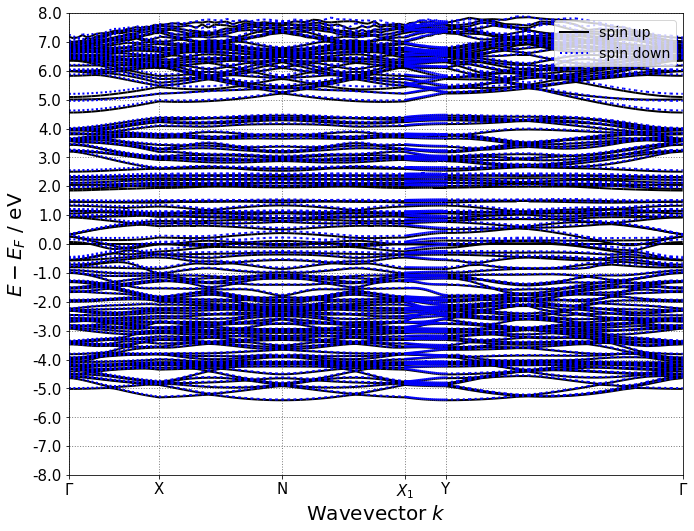

In [8]:
plot(example_material_id, bs_projection=None, dos=False, e_bounds=[-8, +8])

Dimensions of energy array don't match those of 2dm-492: resizing.


<AxesSubplot:xlabel='Wavevector $k$', ylabel='$E-E_F$ / eV'>

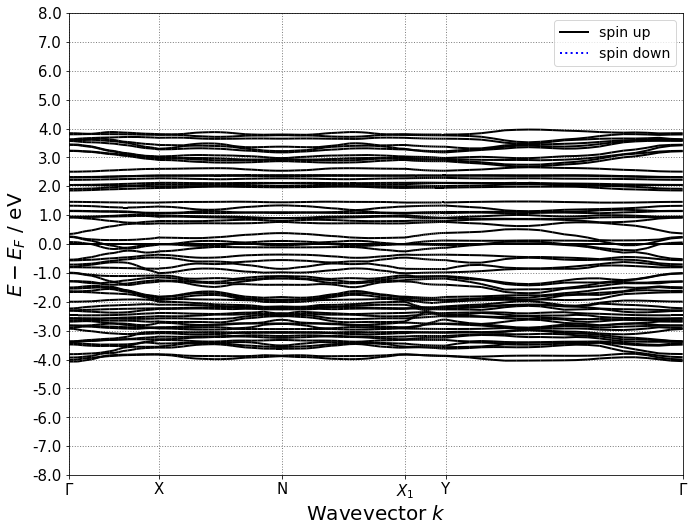

In [9]:
plot_from_bands_picture(example_material_id, resized, e_bounds=[-8, +8])

Resizing seems to be fine - now we need to save the images as PNGs and check they can be loaded properly.

## Saving All Images

In [10]:
def pad_or_crop_to_height(image, desired_height):
    # Get the current size of the image
    current_height = image.shape[0]
    
    if current_height < desired_height:

        # Calculate the pad width for each axis
        pad_width = [((desired_height-current_height) // 2, (desired_height-current_height + 1) // 2),
                     (0, 0)]
                     

        # Pad the image with zeros using np.pad
        image = np.pad(image, pad_width, mode='constant', constant_values=0)

    # Crop the padded image to the desired size
    cropped_image = image[:desired_height]

    return cropped_image

In [12]:
from skimage import io

df_template = pd.read_csv("../fingerprints/template.csv", index_col="ID")
latest_material_that_already_exists = None
padded_array = []
squished_array = []
pad_and_squish_array = []
output_name = f"energies{THRESHOLD}_64_64"


for i, material_id in enumerate(df_template.index):
    input_file_path = DATA_DIRECTORY/f"bands/{material_id}.json"
    output_file_path = DATA_DIRECTORY/f"images"/output_name/f"{material_id}.tiff"
    
    
    # if i < 2299:
    #     continue
    # # if output_file_path.exists():
    # #     latest_material_that_already_exists = material_id
    # #     continue;
    # # elif latest_material_that_already_exists:
    # #     print(f"All images up to {latest_material_that_already_exists}.tiff already exist.")
    # #     latest_material_that_already_exists = None
        
        
        
    
    bands_dict=json.load(open(input_file_path))
    energy_minus_efermi_in_threshold = get_bands_that_average_near_fermi_level(bands_dict)
    energy_minus_efermi_in_threshold[energy_minus_efermi_in_threshold<MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI]=MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI
    energy_minus_efermi_in_threshold[energy_minus_efermi_in_threshold>MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI]=MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI
    output_float = (energy_minus_efermi_in_threshold - MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI) / (MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI - MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI)
    output_float = resize(output_float, (output_float.shape[0], SELECTED_WIDTH), preserve_range=True, mode="edge")
    output_int = ((2**16-1) * output_float).astype(np.uint16)
    io.imsave(output_file_path, output_int)
    
    output_pad = pad_or_crop_to_height(output_float, SELECTED_HEIGHT)
    output_squish = resize(output_float, (SELECTED_HEIGHT, SELECTED_WIDTH), preserve_range=True, mode="edge")
    
    padded_array.append(output_pad)
    squished_array.append(output_squish)

    
    if i % 200 == 0:
        print(i, "/", len(df_template))
        
padded_array = np.array(padded_array)
squished_array.append(output_squish)

np.savez(f"/notebooks/Beta-VAE/data/{output_name}/padded.npz", padded_array)
np.savez(f"/notebooks/Beta-VAE/data/{output_name}/squished.npz", squished_array)

0 / 5270
200 / 5270
400 / 5270
600 / 5270
800 / 5270
1000 / 5270
1200 / 5270
1400 / 5270
1600 / 5270


/tmp/ipykernel_200835/1010724090.py:35: UserWarning: /storage/2dmatpedia/images/energies4_64_64/2dm-1912.tiff is a low contrast image
  io.imsave(output_file_path, output_int)


1800 / 5270
2000 / 5270
2200 / 5270
2400 / 5270
2600 / 5270


/tmp/ipykernel_200835/1010724090.py:35: UserWarning: /storage/2dmatpedia/images/energies4_64_64/2dm-2984.tiff is a low contrast image
  io.imsave(output_file_path, output_int)


2800 / 5270


/tmp/ipykernel_200835/1010724090.py:35: UserWarning: /storage/2dmatpedia/images/energies4_64_64/2dm-3274.tiff is a low contrast image
  io.imsave(output_file_path, output_int)


3000 / 5270
3200 / 5270
3400 / 5270
3600 / 5270
3800 / 5270
4000 / 5270
4200 / 5270
4400 / 5270
4600 / 5270
4800 / 5270
5000 / 5270


/tmp/ipykernel_200835/1010724090.py:35: UserWarning: /storage/2dmatpedia/images/energies4_64_64/2dm-5953.tiff is a low contrast image
  io.imsave(output_file_path, output_int)
/tmp/ipykernel_200835/1010724090.py:35: UserWarning: /storage/2dmatpedia/images/energies4_64_64/2dm-5967.tiff is a low contrast image
  io.imsave(output_file_path, output_int)


5200 / 5270


In [ ]:
dls = DataBlock(
    blocks=(ImageBlock(cls=TiffImage), ImageBlock(cls=TiffImageNoised)), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1),
    item_tfms=[CropPad((SELECTED_HEIGHT, SELECTED_WIDTH))],# AddNoiseTransform(std=1)], #RandomErasingTransform()], #AddNoiseTransform(std=1)],
    batch_tfms=[IntToFloatTensor(div=2**16-1)],
        ).dataloaders(DATA_DIRECTORY/f"images/energies{THRESHOLD}", bs=64)

dls.show_batch()


In [ ]:
load = np.load(f"/notebooks/Beta-VAE/data/{output_name}/padded.npz")
plt.imshow(load["arr_0"][4141])

In [ ]:
load = np.load(DATA_DIRECTORY/"npz"/output_name/"squished.npz")[0]
load.imshow()

In [ ]:
img = TiffImage.create(DATA_DIRECTORY/f"images"/output_name/f"2dm-4000.tiff")
img.show()